# California Housing Price Prediction
This notebook serves as a comprehensive recap of fundamental machine learning concepts through a practical housing price prediction project.

### Learning Objectives
By the end of this notebook, you will be able to:
- Load and preprocess real-world data
- Handle missing values and categorical features
- Create data visualization for insights
- Build and evaluate machine learning models
- Apply feature scaling and transformation techniques

# 0. Setup Python

First, let's import a few common modules and ensure MatplotLib plots figures inline. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥ 1.0.1.

In [66]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥ 1.0.1 is required
from packaging import version
import sklearn
print(sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt


1.5.1


# 1. Data Collection and Loading

## Dataset Overview
We'll be working with the California Housing dataset, which contains data from the 1990 California census. Our goal is to predict median house values in California districts.

### Features Description
- `longitude`, `latitude`: Geographic location
- `housing_median_age`: Median age of houses in the district
- `total_rooms`: Total number of rooms
- `total_bedrooms`: Total number of bedrooms
- `population`: Number of people in the district
- `households`: Number of households
- `median_income`: Median income in the district
- `ocean_proximity`: Location relative to the ocean
- `median_house_value`: Target variable (what we want to predict)

## Download the Data

In [67]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

## Take a Quick Look at the Data Structure

In [68]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [69]:
housing.shape

(20640, 10)

In [70]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [71]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [72]:
housing[['housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity']].describe()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Observations: 
- 20640 districts in the dataset
- total_bedrooms is missing for 207 districts --> take care of this later
- All attributes are numerical, except the ocean_proximity field, which is _object_
object
- We see that it is categorical: 

In [73]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

The describe() method shows a summary of
the numerical attributes

In [74]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


#### Plot a histogram for each numerical attribute

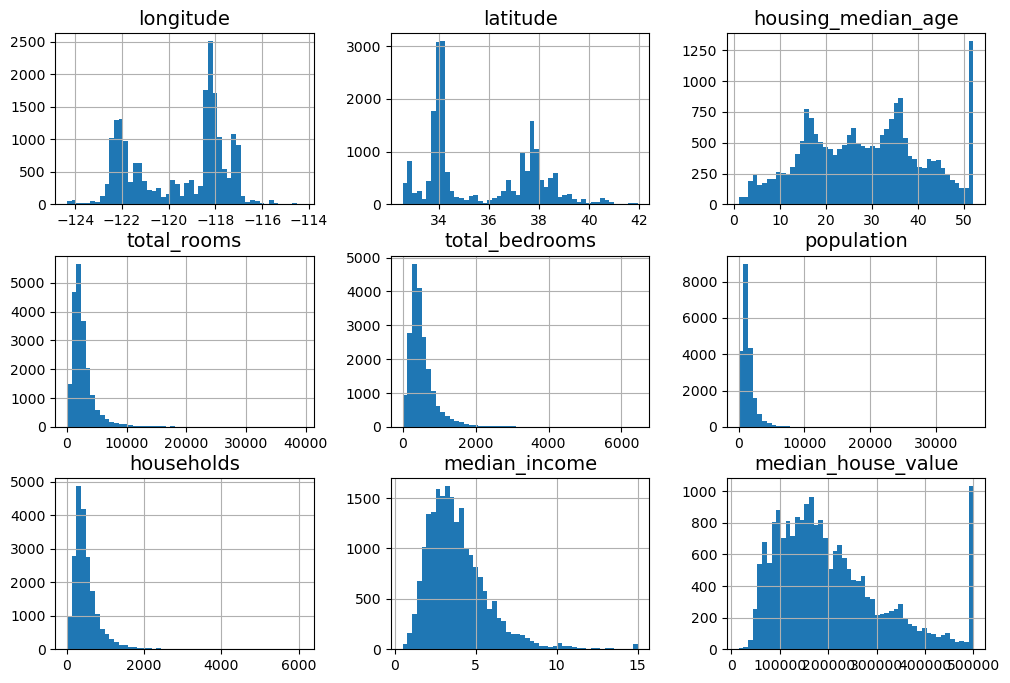

In [75]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
plt.show()

Observations: 
1. Median (yearly) income is not expressed in US dollars.  After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers represent roughly
tens of thousands of dollars (e.g., 3 actually means about \$30,000). Working with preprocessed attributes is common in Machine
Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.  
2. The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target
attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your
client team (the team that will use your system’s output) to see if this is a problem or not. If they tell you that they need precise predictions
even beyond $500,000, then you have two options:
    - Collect proper labels for the districts whose labels were capped.
    - Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond  500,000).
3. These attributes have very different scales. We will discuss this later in this chapter, when we explore feature scaling.
4. Finally, many histograms are tail-heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder
for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped
distributions.

## Create a Test Set

# 2. Data Splitting and Validation Strategy

## Why Split the Data?
Before any data exploration or preprocessing, we need to separate our test set to avoid data leakage. This ensures that:
- We have a truly independent test set
- Our model evaluation will be realistic
- We don't accidentally use information from the test set during development

## Splitting Approaches
We'll use two methods:
1. Random splitting (simple but may introduce sampling bias)
2. Stratified sampling (ensures representative splits based on income categories)

### Important Warning ⚠️
Never explore or preprocess the test set! It should remain untouched until the final evaluation.

In [76]:
# to make this notebook's output identical at every run
import numpy as np
np.random.seed(42)

If you don't use _np.random.seed(42)_ and you run the program again, it will generate a different test set! Over time, you (or your Machine Learning
algorithms) will get to see the whole dataset, which is what you want to avoid.

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is _train_test_split()_

In [77]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [78]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-122.38,40.67,10.0,2281.0,444.0,1274.0,438.0,2.2120,65600.0,INLAND
3024,-118.37,33.83,35.0,1207.0,207.0,601.0,213.0,4.7308,353400.0,<1H OCEAN
15663,-117.24,32.72,39.0,3089.0,431.0,1175.0,432.0,7.5925,466700.0,NEAR OCEAN
20484,-118.44,34.05,18.0,4780.0,1192.0,1886.0,1036.0,4.4674,500001.0,<1H OCEAN
9814,-118.44,34.18,33.0,2127.0,414.0,1056.0,391.0,4.3750,286100.0,<1H OCEAN


- Random sampling is fine if your dataset is large enough (relative to the number of attributes)
- But you run the risk of introducing a significant sampling bias
- Suppose the median income is a very important attribute to predict median housing prices.
- Then make sure that you have +/- the same distribution in your test set as in the whole dataset. 
- This is called __stratified sampling__ which is especially useful if you a have skew dataset.
- Since the median income is a continuous numerical attribute, you first need to create an income category attribute.



In [79]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [80]:
housing["income_cat"].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

<Axes: >

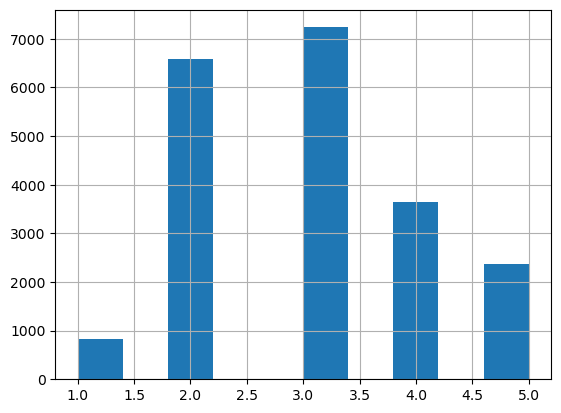

In [81]:
housing["income_cat"].hist()

See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

In [82]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

Let's check if this worked: are income category proportions in test set equal to complete dataset? 

In [83]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [84]:
housing["income_cat"].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

Yes!

Now we can remove _income_cat_. 

In [85]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 3. Exploratory Data Analysis

## Goals of This Section
1. Understand the data distribution
2. Identify patterns and relationships
3. Detect potential data quality issues
4. Gain insights for feature engineering

## Key Visualizations
We'll explore:
1. Geographic distribution of house prices
2. Correlation between features
3. Distribution of numerical features
4. Patterns in categorical data

Remember: Good visualization is key to understanding your data and making informed decisions about preprocessing and modeling.

In [86]:
housing = strat_train_set.copy()

## Visualizing Geographical Data

<Axes: xlabel='longitude', ylabel='latitude'>

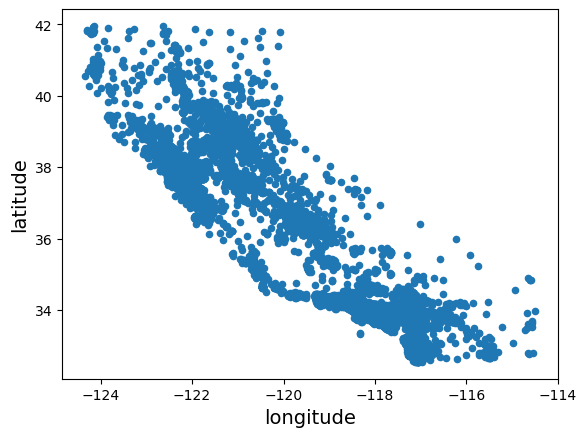

In [87]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points

<Axes: xlabel='longitude', ylabel='latitude'>

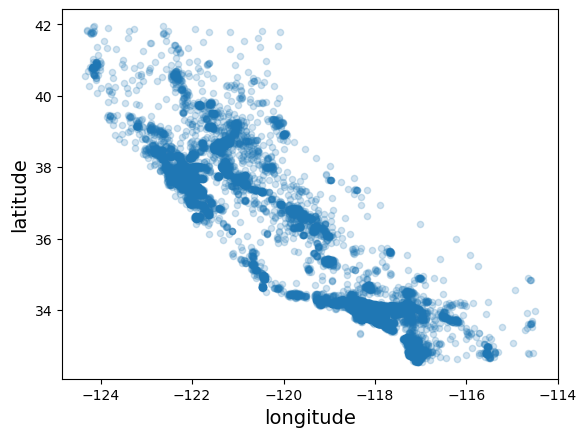

In [88]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)

Now let’s look at the housing prices. The radius of each circle represents the district’s population (option s), and the color represents the
price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices). 

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611 ). Thanks to Wilmer Arellano for pointing it out.

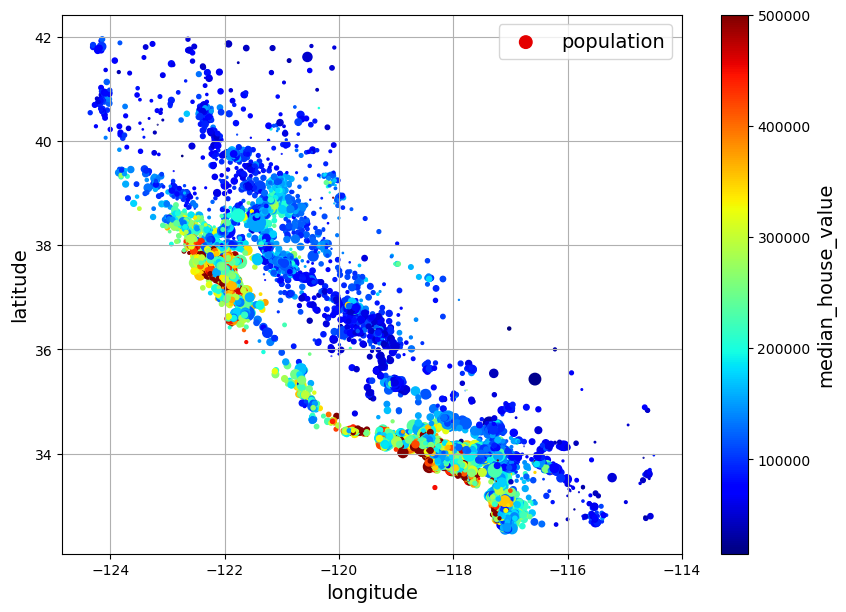

In [89]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

#### START NICE TO KNOW

In [90]:

# Use existing California image from images folder
images_path = os.path.join(".", "images")
filename = "california.png"

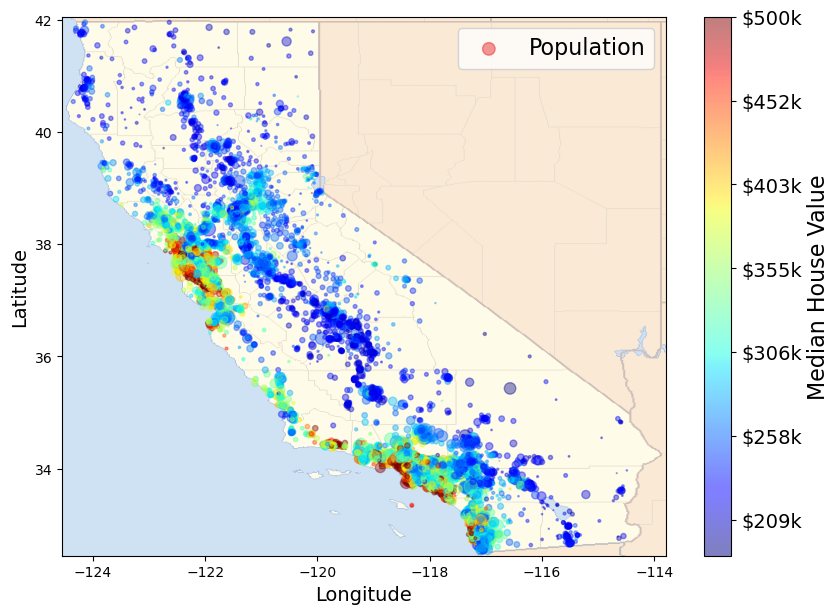

In [91]:
import matplotlib.image as mpimg
california_img = mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

#### END NICE TO KNOW

# 4. Data Preprocessing Pipeline

## Overview
In this section, we'll prepare our data for machine learning algorithms through several steps:

1. **Data Cleaning**
   - Handling missing values
   - Converting categorical data to numerical
   
2. **Feature Engineering**
   - Feature scaling
   - Creating transformation pipelines
   
3. **Data Transformation**
   - Standardization
   - One-hot encoding for categorical variables

These steps are crucial for ensuring our data is in the right format and scale for machine learning algorithms to work effectively.

Let's revert to the original training set and separate the target (note that `strat_train_set.drop()` creates a copy of `strat_train_set` without the column, it doesn't actually modify `strat_train_set` itself, unless you pass `inplace=True`):

In [92]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. We saw earlier that the
total_bedrooms attribute has some missing values, so let’s fix this. You have three options:

```python
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

To demonstrate each of them, let's create a copy of the housing dataset, but keeping only the rows that contain at least one null. Then it will be easier to visualize exactly what each option does:

In [93]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [94]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [95]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [96]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3

C:\Users\billo\AppData\Local\Temp\ipykernel_23344\760120979.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3


In [97]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


We decide to choose option 3 and use the sklearn class SimpleImputer

In [98]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [99]:
imputer

SimpleImputer(strategy='median')

Remove the text attribute because median can only be calculated on numerical attributes:

In [100]:
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [101]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

Only the total_bedrooms attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the imputer to all the numerical attributes:

In [102]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Check that this is the same as manually computing the median of each attribute:

In [103]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Now you can use this “trained” imputer to transform the training set by replacing missing values with the learned medians:

In [104]:
X = imputer.transform(housing_num)

The result is a plain NumPy array containing the transformed features. If you want to put it back into a pandas DataFrame, it’s simple:

In [105]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,index=housing_num.index)

In [106]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


In [107]:
housing_tr.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.573125,35.637746,28.577156,2639.402798,537.881298,1425.513929,499.990189,3.870428
std,2.000624,2.133294,12.585738,2185.287466,421.831667,1094.795467,382.865787,1.891936
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.800000,33.930000,18.000000,1447.000000,297.000000,787.000000,279.000000,2.562500
50%,-118.510000,34.260000,29.000000,2125.000000,434.000000,1167.000000,408.000000,3.538500
75%,-118.010000,37.720000,37.000000,3154.000000,642.000000,1726.000000,603.000000,4.750000
max,-114.490000,41.950000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100


## Handling Text and Categorical Attributes

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [108]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


Most Machine Learning algorithms prefer to work with numbers, so let’s convert these categories from text to numbers.

In [109]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [110]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One **issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values**. This may be fine in
some cases (e.g., for ordered categories such as “bad,” “average,” “good,” and “excellent”), but it is obviously not the case for the ocean_proximity column
(for example, categories 0 and 4 are clearly more similar than categories 0 and 1).

A common **solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise)**, and so on. The new attributes are sometimes called dummy attributes.  

This is called **One Hot Encoding**. 

In [111]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very useful when you have categorical attributes with thousands of
categories. After one-hot encoding, we get a matrix with thousands of columns, and the matrix is full of 0s except for a single 1 per row. Using up
tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the nonzero elements. You can use it
mostly like a normal 2D array, but if you really want to convert it to a (dense) NumPy array, just call the toarray() method:

In [112]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [113]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [114]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [115]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [116]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

## Feature Scaling

One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. 

This is the case for the housing data: 
- the total number of rooms ranges from about 6 to 39.320
-  the median incomes only range from 0 to 15. 

Note that scaling the target values is generally not required. There are two common ways to get all attributes to have the same scale: 

- min-max scaling
- standardization.

__Min-max scaling__ (aka __normalization__)
- simplest scaler
- values are shifted and rescaled so that they end up ranging from 0 to 1. 
- subtract the min value and divide by the max minus the min. 
- Scikit-Learn provides a transformer called `MinMaxScaler` for this. 

__Standardization__ 
- first it subtracts the mean value (so standardized values always have a zero mean)
- then it divides by the standard deviation so that the resulting distribution has unit variance. 
- Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). 
- Standardization is much less affected by outliers. 
- For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–
15 down to 0–0.15, whereas standardization would not be much affected.

__WARNING__

As with all the transformations, it is important to _fit the scalers to the training data only, not to the full dataset_ (including the test set)only: never use `fit()` or `fit_transform()` for anything
else than the training set.. Only then can you use them to transform the training set and the test set (and new data).

In [117]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [118]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

When a feature’s distribution has a heavy tail (i.e., when values far from the mean
are not exponentially rare), both min-max scaling and standardization will squash
most values into a small range. Machine learning models generally don’t like this
at all, as you will see in Chapter 4. So before you scale the feature, you should first
transform it to shrink the heavy tail, and if possible to make the distribution roughly
symmetrical. For example, a common way to do this for positive features with a heavy
tail to the right is to replace the feature with its square root (or raise the feature to
a power between 0 and 1). If the feature has a really long and heavy tail, then replacing the feature with its logarithm may help. The  figure below shows how much better this feature looks
when you compute its log: it’s very close to a Gaussian distribution (i.e., bell-shaped).

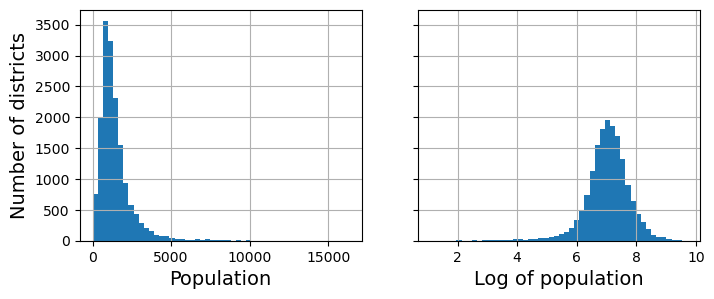

In [119]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
plt.show()

## Transformation Pipelines
Scikit-Learn provides the `Pipeline` class to help with such sequences of transformations.

- The Pipeline constructor takes a list of name/estimator pairs defining a sequence of steps. 
- All but the last estimator must be transformers (i.e., they must have a fit_transform() method). 
- The names can be anything you like (as long as they are unique and don’t contain double underscores, __); they will come in handy later for hyperparameter tuning. 
- The estimators must all be transformers (i.e., they must have a `fit_transform()` method), except for the last one, which can be anything: a transformer, a predictor, or any other type of estimator.
- When you call the pipeline’s fit() method, it calls fit_transform() sequentially on all transformers, passing the output of each call as the parameter to the next call until it reaches the final estimator, for which it calls the fit() method.
  
- The pipeline exposes the same methods as the final estimator. 
- In this example, the last estimator is a `StandardScaler`, which is a transformer, so the pipeline has a `transform()` method that applies all the transforms to the data in sequence (and of course also a `fit_transform()` method, which is the one we used).
  
Now let's build a pipeline for preprocessing the numerical attributes:

In [120]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

- If you don’t want to name the transformers, you can use the `make_pipeline()` function instead.
- It takes transformers as positional arguments and creates a `Pipeline` using the names of the transformers’ classes, in lowercase and without underscores (e.g., "simpleimputer"):

In [121]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

When you call the pipeline’s `fit()` method, it calls `fit_transform()` sequentially on
all the transformers, passing the output of each call as the parameter to the next call
until it reaches the final estimator, for which it just calls the `fit()` method.

In [122]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

- Now also add the categorical attribute(s). 
- It would be more convenient to have a single transformer capable of handling all columns, applying the appropriate transformations to each column. 
- For this, you can use a `ColumnTransformer`. 
- For example, the following `ColumnTransformer` will apply 
  - `num_pipeline` (the one we just defined) to the numerical attributes and 
  - `cat_pipeline` to the categorical attribute:

In [123]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),  # missing categorical values are filled with most frequent values
    OneHotEncoder(handle_unknown="ignore"))  

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

- Since listing all the column names is not very convenient, Scikit-Learn provides a `make_column_selector()` function that returns a selector function you can use to automatically select all the features of a given type, such as numerical or categorical.
- You can pass this selector function to the `ColumnTransformer` instead of column names or indices. 
- Moreover, if you don’t care about naming the transformers, you can use `make_column_transformer()`, which chooses the names for you, just like `make_pipeline()` does. 
- For example, the following code creates the same `ColumnTransformer` as earlier, except the transformers are automatically named "pipeline-1" and "pipeline-2" instead of "num" and "cat":

In [124]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

Now we’re ready to apply this `ColumnTransformer` to the housing data:

In [125]:
housing_prepared = preprocessing.fit_transform(housing)

In [126]:
housing_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2030985 ,  1.27611874,  0.35142777, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41803793,  0.94797769,  1.22545939, ...,  0.        ,
         0.        ,  1.        ]])

# 5. Model Development and Evaluation

## Model Selection
In this section, we'll:
1. Train a basic linear regression model
2. Evaluate its performance using RMSE
3. Discuss model limitations and potential improvements

### Why Linear Regression?
- Simple to understand and implement
- Serves as a good baseline model
- Helps identify if we need more complex models

### Evaluation Metrics
We'll use Root Mean Square Error (RMSE) to evaluate our model's performance:
- RMSE measures the standard deviation of the predictions from the actual values
- Lower RMSE values indicate better model performance
- The metric is in the same units as our target variable (dollars)

Now we are ready to select and train a machine learning model. Start with a very basis model: linear regression (You know this from data science fundamentals correct?). 

## Training and Evaluating on the Training Set

In [127]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())  
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002DCA7022360>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002DCA3641160>)])),
                ('linearregression', LinearRegression())])

Let's try the full preprocessing pipeline on a few training instances:

In [128]:
housing_predictions = lin_reg.predict(housing) # here the advantage of creating a pipeline becomes clear. 
housing_predictions  # -2 = rounded to the nearest hundred

array([270886.93228264, 334830.60618945, 119856.18008898, ...,
       195962.32147342, 283097.58349723, 233352.27953643])

Compare against the actual values:

In [129]:
housing_labels.values

array([458300., 483800., 101700., ..., 148800., 500001., 233300.])

Well, it works, but not always: the first prediction is way off, while the other predictions are better. Remember that we chose to use the RMSE as our performance measure, so we want to measure this regression model’s RMSE on the whole training
set using Scikit-Learn’s `mean_squared_error()` function, with the `squared` argument set to `False`:

RMSE on training set: 

In [130]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse

c:\Users\billo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


68232.83515124217

This is better than nothing, but clearly not a great score: the median_housing_values of most districts range between \\$120.000 and \\$265.000, so a typical prediction error of \\$68.232 is really not very satisfying. This is an example of a model underfitting the training data (The model has not learned the correct/necessary patterns). When this happens it can mean 
- that the features do not provide enough information to make good predictions, or 
- that the model is not powerful enough. 
 
Some ways to fix underfitting are 
- to select a more powerful model
- to feed the training algorithm with better features, or 
- to reduce the constraints on the model. 

This model is not regularized, which rules out the last option. You could try to add more features, but first you want to try a more complex model to see how it does.